We want to curate the data from [genesets enriched in PPI](ppi_neighborhoods.ipynb). We will look with special interest at those that involve:

1. Tumor drivers
2. Switches were both isoforms are protein-coding.
3. Both PPI gains and losses.
4. Are coherent with current annotation.

A look at the [networks](../results/networks) yielded 4 candidates:

* BIOCARTA_WNT_PATHWAY
* hnRNP
* BIOCARTA_G1_PATHWAY
* Post-splicing, specifically the subset involved in translation initiation.

In [1]:
source("../data/env/variables.R")
source("../wisdom/code/r/data_analysis_environment.R")
source("../wisdom/code/r/clean_theme.R")

options("readr.num_columns" = 0)

# read switches that affect PPIs
switches <- read_tsv("../data/pancancer/candidateList_full.tsv") %>%
    filter(Reliable==1 & Origin=="Tumor")

switches.split <- read_tsv("../data/pancancer/candidateList_full.tumorSplit.tsv") %>%
    filter(EnoughRecurrence == 1 & NotNoise==1 & IsModel==1 & Origin=="Tumor" & PPI == 1)

potus <- switches %>%
    select(GeneId,Symbol,Normal_transcript,Tumor_transcript, Recurrence,
           Affects_mutated_feature,PPI,Pannegative,Candidate)

id2symbol <- read_tsv("../data/mutations/proteome_information.txt") %>%
    select(GeneId,Symbol) %>%
    unique

# unique drivers
drivers <- read_tsv("../data/intogen_cancer_drivers-2014.12b/Mutational_drivers_per_tumor_type.tsv",comment="#") %>%
    set_colnames(c("Symbol","Tumor")) %>%
    .$Symbol %>%
    unique

# latest version of ucsc genes
latestVersion <- read_tsv("../data/knownGenes.ucsc2013.txt") %>%
    mutate(Transcript = strsplit(name, ".", fixed = T) %>% unlist %>% .[c(T,F)],
           CDS = ifelse(cdsStart == cdsEnd, 0, 1))

# read expression
proteome <- read_tsv("../data/mutations/proteome_information.txt") %>%
    set_colnames(c("Tumor","GeneId","Symbol","Transcript","TPM","ProteinLength","asEvidence")) %>%
    mutate(asEvidence = as.numeric(asEvidence=="True"))
        
# read interactions
ppi.network <- read_tsv("../data/eporta/raw_tables/interactions_found_more_than_three_times.txt", col_names = F) %>%
    select(-X3) %>%
    set_colnames(c("Gene1","Gene2")) %>%
    merge(id2symbol, by.x = "Gene1", by.y = "GeneId") %>%
    merge(id2symbol, by.x = "Gene2", by.y = "GeneId", suffixes = c("","2")) %>%
    set_colnames(c("Gene1","Gene2","Symbol1","Symbol2"))
    
ppi.file <- "../data/eporta/raw_tables/Switched_interactions_consensus.txt"

## get max number of columns (necessary for reading)
no_col <- max(count.fields(ppi.file,sep = "\t"))
no_col.ppi <- (no_col-6)/2
ppi.cols <- paste(c("Origin","Interaction"), floor(seq(1,no_col.ppi,0.5)), sep="_")

## read table
ppi.split <- read.table(ppi.file,header=F,fill=T,col.names=1:no_col) %>%
    set_colnames(c("GeneId","Symbol","Normal_transcript","Tumor_transcript","partnerId","partnerSymbol",ppi.cols)) %>%
    # all Origin columns contail "DDI_match", so we can disregard them
    select(-starts_with("Origin_")) %>%
    # convert from wide to long table format
    reshape2::melt(id.vars = c("GeneId","Symbol","Normal_transcript","Tumor_transcript","partnerId","partnerSymbol"),
                   value.name = "Interaction") %>%
    select(-variable) %>%
    # remove cases with no interaction described
    filter(Interaction != "") %>%
    # split interaction information
    separate(Interaction, into = c("What","partnerTranscript","Pfams"), sep = "-") %>%
    mutate(What = plyr::revalue(What, replace = c("Gained"="Gain", "Lost"="Loss", "Kept"="Unaffected"))) %>%
    # remove pfams columns (account for different domains for the same interaction)
    select(-Pfams) %>%
    # remove several instances of the same isoform
    unique %>%
    # annotate with switch info
    merge(switches.split) %>%
    ## remove tumor specific measures
    select(-Recurrence,-Affects_mutated_feature,-PPI,-Pannegative) %>%
    merge(potus, by=c('GeneId','Symbol','Normal_transcript','Tumor_transcript','Candidate'), 
          suffixes=c(".split",".pancancer")) %>%
    # consider only the most abundant isoform as partner: one interaction per pair & only expressed genes
    merge(proteome, by.x = c("Tumor","partnerTranscript"), by.y = c("Tumor","Transcript"),
          suffixes = c(".switch",".partner"))
    
ppi <- ppi.split %>%
    group_by(GeneId.switch,Symbol.switch,Normal_transcript,Tumor_transcript,GeneId.partner,partnerSymbol) %>%
    
    summarise(Unaffected = sum(What=="Unaffected"), Gain = sum(What=="Gain"), Loss = sum(What=="Loss")) %>%
    ungroup() %>%
    set_colnames(c("GeneId","Symbol","Normal_transcript","Tumor_transcript",
                   "partnerGeneId","partnerSymbol","Unaffected","Gain","Loss")) %>%
    mutate(Tag = ifelse(Loss > 0, "Loss", "Unaffected"),
           Tag = ifelse(Gain > 0, "Gain", Tag)) %>%
    merge(switches)

Loading tidyverse: ggplot2
Loading tidyverse: tibble
Loading tidyverse: tidyr
Loading tidyverse: readr
Loading tidyverse: purrr
Loading tidyverse: dplyr
Conflicts with tidy packages ---------------------------------------------------
filter(): dplyr, stats
lag():    dplyr, stats
Warning message:
“attributes are not identical across measure variables; they will be dropped”

# BIOCARTA_WNT_PATHWAY
## Switches in the pathway

In [2]:
BIOCARTA_WNT_PATHWAY <- c(1457,7471,1453,1452,2932,8945,11197,1499,8321,5515,
                          1387,51176,7088,595,1487,51701,324,6885,1855,5467,
                          10023,8312,3065,10454,4089,4609)

# genes with a switch in the pathway
switches %>%
    filter(GeneId %in% BIOCARTA_WNT_PATHWAY) %>%
    select(GeneId) %>%
    unique %>%
    nrow

switches %>%
    filter(GeneId %in% BIOCARTA_WNT_PATHWAY) %>%
    select(Symbol) %>%
    unique %>%
    t

[1] 10

Symbol,AXIN1,CREBBP,CTNNB1,CTBP1,LEF1,CSNK1A1,PPARD,MAP3K7,TLE1,NLK


In [3]:
# check how many cases there are transcripts with the same id (ie similar exon structure and coordinates)
current.switches <- switches %>%
    filter(GeneId %in% BIOCARTA_WNT_PATHWAY) %>%
    mutate(Normal_transcript.r = strsplit(Normal_transcript, ".", fixed = T) %>% unlist %>% .[c(T,F)],
           Tumor_transcript.r = strsplit(Tumor_transcript, ".", fixed = T) %>% unlist %>% .[c(T,F)]) %>%
    merge(latestVersion, by.x=c("Normal_transcript.r","CDS_Normal"), by.y=c("Transcript","CDS")) %>%
    merge(latestVersion, by.x=c("Tumor_transcript.r","CDS_Tumor"), by.y=c("Transcript","CDS"))

current.switches$Symbol %>% unique %>% length
current.switches$Symbol %>% unique

[1] 4

[1] "AXIN1"  "CREBBP" "CTNNB1" "PPARD"

In [4]:
# genes were both transcripts are protein-coding and affect a PPI
current.switches %>%
    filter(GeneId %in% BIOCARTA_WNT_PATHWAY & PPI == 1 & CDS_Normal == 1 & CDS_Tumor == 1) %>%
    select(GeneId) %>%
    unique %>%
    nrow

current.switches %>%
    filter(GeneId %in% BIOCARTA_WNT_PATHWAY & PPI == 1 & CDS_Normal == 1 & CDS_Tumor == 1) %>%
    select(Symbol) %>%
    unique %>%
    t

[1] 1

,1
Symbol,PPARD


In [5]:
source("../data/env/getPPINetwork.R")
library(ggnetwork)
ppiPalette = c("Gain" = "#31a354", "Loss" = "#f03b20", "Unaffected" = "#d9d9d9", "Draw" = "#d9d9d9")

ppi.filt <- merge(ppi, current.switches %>% select(GeneId, Normal_transcript, Tumor_transcript) )
tags <- ppi.filt %>% filter(partnerGeneId %in% BIOCARTA_WNT_PATHWAY) %>% select(Tag) %>% unique

if(nrow(tags)) {
    if (any(tags != "Unaffected")){
    nw <- getPPINetwork(BIOCARTA_WNT_PATHWAY, ppi.network, ppi.filt)

    # number of edges
    length(nw %e% "Effect")

    # add node attributes
    nw %v% "Gene" <- ifelse(nw %v% "vertex.names" %in% drivers, "Driver", "Non-driver")
    nw %v% "Switched" <- ifelse(nw %v% "vertex.names" %in% current.switches$Symbol, "Switched", "Non-switched")

    ggplot(nw, aes(x = x, y = y, xend = xend, yend = yend)) +
        geom_edges(aes(color = Effect, linetype = Consensus)) +
        geom_nodelabel(aes(label = vertex.names, fill = Gene, alpha = Switched), size = 5, color = "white") +
        scale_color_manual(values = ppiPalette) +
        scale_alpha_manual(values = c("Switched" = 1, "Non-switched" = 0.5)) +
        scale_fill_manual(values = c("Driver" = "black", "Non-driver" = "#0570b0")) +
        scale_linetype_manual(values = c("Yes" = "solid", "No" = "dashed")) +
        lims( x = c(-.10, 1.10))+ 
        theme(axis.line=element_blank(),axis.text.x=element_blank(),
              axis.text.y=element_blank(),axis.ticks=element_blank(),
              axis.title.x=element_blank(),axis.title.y=element_blank(),
              legend.position="bottom")
    }
}

network: Classes for Relational Data
Version 1.13.0 created on 2015-08-31.
copyright (c) 2005, Carter T. Butts, University of California-Irvine
                    Mark S. Handcock, University of California -- Los Angeles
                    David R. Hunter, Penn State University
                    Martina Morris, University of Washington
                    Skye Bender-deMoll, University of Washington
 For citation information, type citation("network").
 Type help("network-package") to get started.


Attaching package: ‘igraph’

The following objects are masked from ‘package:network’:

    %c%, %s%, add.edges, add.vertices, delete.edges, delete.vertices,
    get.edge.attribute, get.edges, get.vertex.attribute, is.bipartite,
    is.directed, list.edge.attributes, list.vertex.attributes,
    set.edge.attribute, set.vertex.attribute

The following objects are masked from ‘package:dplyr’:

    %>%, as_data_frame, groups, union

The following objects are masked from ‘package:purrr’:

    

# hnRNP
## Switches in the pathway

In [6]:
hnRNP <- c("FUS","HNRNPA0","HNRNPA1","HNRNPA2B1","HNRNPA3","HNRNPAB","HNRNPABD",
           "HNRNPC","HNRNPCL1","HNRNPCL2","HNRNPD","HNRNPF","  HNRNPH1","HNRNPH2",
           "HNRNPH3","HNRNPK","HNRNPL","HNRNPM","HNRNPR","HNRNPU","HNRNPUL1",
           "HNRNPUL2","HNRPDL","HNRPLL","HNRPQ","MSL1","MSL2","PCBP1","PCBP2","PCBP3",
           "PCBP4","RALY","RALYL","RARY","RBMX","RBMXL2","SQD","SYNCRIP")

hnRNP <- id2symbol %>%
    filter(Symbol %in% hnRNP) %>%
    .$GeneId

# genes with a switch in the pathway
switches %>%
    filter(GeneId %in% hnRNP) %>%
    select(GeneId) %>%
    unique %>%
    nrow

switches %>%
    filter(GeneId %in% hnRNP) %>%
    select(Symbol) %>%
    unique %>%
    t

[1] 16

Symbol,HNRNPU,HNRNPF,HNRNPH3,PCBP2,HNRNPC,FUS,MSL1,HNRPLL,PCBP4,HNRNPD,HNRPDL,SYNCRIP,HNRNPK,HNRNPH2,RBMX,HNRNPUL1


In [7]:
# check how many cases there are transcripts with the same id (ie similar exon structure and coordinates)
current.switches <- switches %>%
    filter(GeneId %in% hnRNP) %>%
    mutate(Normal_transcript.r = strsplit(Normal_transcript, ".", fixed = T) %>% unlist %>% .[c(T,F)],
           Tumor_transcript.r = strsplit(Tumor_transcript, ".", fixed = T) %>% unlist %>% .[c(T,F)]) %>%
    merge(latestVersion, by.x=c("Normal_transcript.r","CDS_Normal"), by.y=c("Transcript","CDS")) %>%
    merge(latestVersion, by.x=c("Tumor_transcript.r","CDS_Tumor"), by.y=c("Transcript","CDS"))

current.switches$Symbol %>% unique %>% length
current.switches$Symbol %>% unique

[1] 7

[1] "PCBP2"   "HNRNPC"  "MSL1"    "PCBP4"   "HNRNPD"  "SYNCRIP" "HNRNPK"

In [8]:
# genes were both transcripts are protein-coding and affect a PPI
current.switches %>%
    filter(GeneId %in% hnRNP & PPI == 1 & CDS_Normal == 1 & CDS_Tumor == 1) %>%
    select(GeneId) %>%
    unique %>%
    nrow

current.switches %>%
    filter(GeneId %in% hnRNP & PPI == 1 & CDS_Normal == 1 & CDS_Tumor == 1) %>%
    select(Symbol) %>%
    unique %>%
    t

[1] 1

,1
Symbol,MSL1


Loading required package: sna
Loading required package: statnet.common
sna: Tools for Social Network Analysis
Version 2.4 created on 2016-07-23.
copyright (c) 2005, Carter T. Butts, University of California-Irvine
 For citation information, type citation("sna").
 Type help(package="sna") to get started.


Attaching package: ‘sna’

The following objects are masked from ‘package:igraph’:

    betweenness, bonpow, closeness, components, degree, dyad.census,
    evcent, hierarchy, is.connected, neighborhood, triad.census



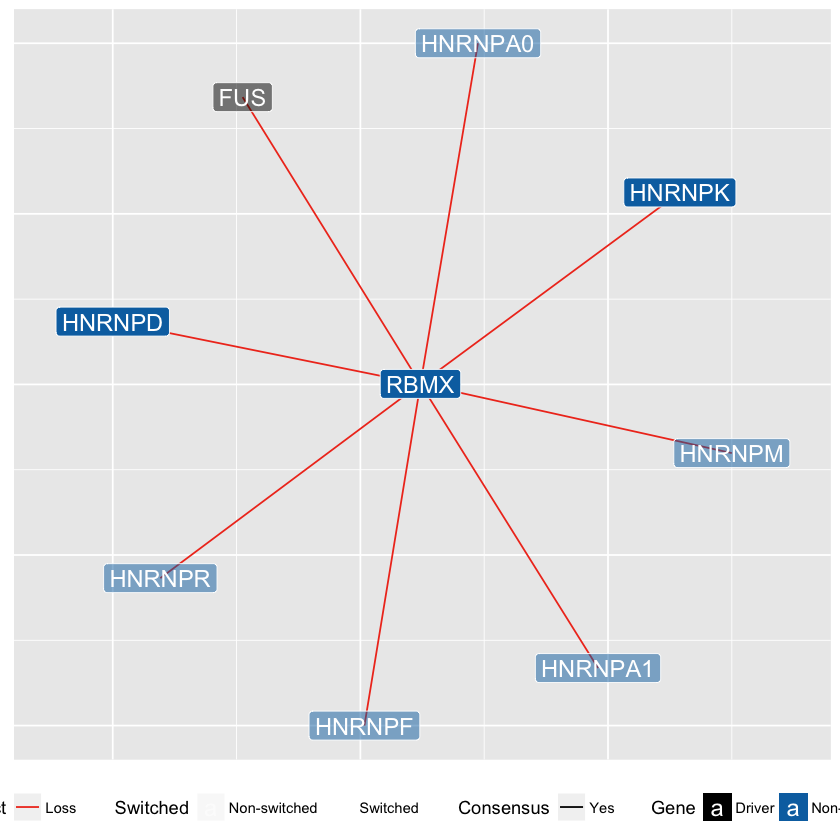

In [9]:
ppi.filt <- merge(ppi, current.switches %>% select(GeneId, Normal_transcript, Tumor_transcript) )

ppi.filt <- merge(ppi, switches %>% 
                          filter(Symbol=="RBMX" & PPI==1) %>% 
                          select(GeneId, Normal_transcript, Tumor_transcript) ) %>%
    rbind(ppi.filt)

if(any((ppi.filt %>% filter(partnerGeneId %in% hnRNP) %>% select(Tag) %>% unique) != "Unaffected")){
    nw <- getPPINetwork(hnRNP, ppi.network, ppi.filt)

    # number of edges
    length(nw %e% "Effect")

    # add node attributes
    nw %v% "Gene" <- ifelse(nw %v% "vertex.names" %in% drivers, "Driver", "Non-driver")
    nw %v% "Switched" <- ifelse(nw %v% "vertex.names" %in% current.switches$Symbol, "Switched", "Non-switched")
    nw %v% "Switched" <- ifelse(nw %v% "vertex.names" == "RBMX", "Switched", nw %v% "Switched")

    ggplot(nw, aes(x = x, y = y, xend = xend, yend = yend)) +
        geom_edges(aes(color = Effect, linetype = Consensus)) +
        geom_nodelabel(aes(label = vertex.names, fill = Gene, alpha = Switched), size = 5, color = "white") +
        scale_color_manual(values = ppiPalette) +
        scale_alpha_manual(values = c("Switched" = 1, "Non-switched" = 0.5)) +
        scale_fill_manual(values = c("Driver" = "black", "Non-driver" = "#0570b0")) +
        scale_linetype_manual(values = c("Yes" = "solid", "No" = "dashed")) +
        lims( x = c(-.10, 1.10))+ 
        theme(axis.line=element_blank(),axis.text.x=element_blank(),
              axis.text.y=element_blank(),axis.ticks=element_blank(),
              axis.title.x=element_blank(),axis.title.y=element_blank(),
              legend.position="bottom")
}

# BIOCARTA_G1_PATHWAY
## Switches in the pathway

In [10]:
BIOCARTA_G1_PATHWAY <-c(1869,7027,2932,1029,1027,1026,983,7042,8900,1030,7040,
                        7043,595,1017,1019,25,5925,6502,7157,1021,1719,993,
                        472,545,3065,4088,4089,898)

# genes with a switch in the pathway
switches %>%
    filter(GeneId %in% BIOCARTA_G1_PATHWAY) %>%
    select(GeneId) %>%
    unique %>%
    nrow

switches %>%
    filter(GeneId %in% BIOCARTA_G1_PATHWAY) %>%
    select(Symbol) %>%
    unique %>%
    t

[1] 14

Symbol,TGFB2,CDK1,CDK2,TFDP1,TP53,CCNE1,CDC25A,SKP2,CDKN2A,CDKN2B,ABL1,DHFR,SMAD3,CDK6


In [11]:
# check how many cases there are transcripts with the same id (ie similar exon structure and coordinates)
current.switches <- switches %>%
    filter(GeneId %in% BIOCARTA_G1_PATHWAY) %>%
    mutate(Normal_transcript.r = strsplit(Normal_transcript, ".", fixed = T) %>% unlist %>% .[c(T,F)],
           Tumor_transcript.r = strsplit(Tumor_transcript, ".", fixed = T) %>% unlist %>% .[c(T,F)]) %>%
    merge(latestVersion, by.x=c("Normal_transcript.r","CDS_Normal"), by.y=c("Transcript","CDS")) %>%
    merge(latestVersion, by.x=c("Tumor_transcript.r","CDS_Tumor"), by.y=c("Transcript","CDS"))

current.switches$Symbol %>% unique %>% length
current.switches$Symbol %>% unique

[1] 10

[1] "CDK1"   "TFDP1"  "CDC25A" "SKP2"   "CDKN2A" "CDKN2B" "ABL1"   "CDK6"  
 [9] "CDK2"   "SMAD3"

In [12]:
# genes were both transcripts are protein-coding and affect a PPI
current.switches %>%
    filter(GeneId %in% BIOCARTA_G1_PATHWAY & PPI == 1 & CDS_Normal == 1 & CDS_Tumor == 1) %>%
    select(GeneId) %>%
    unique %>%
    nrow

current.switches %>%
    filter(GeneId %in% BIOCARTA_G1_PATHWAY & PPI == 1 & CDS_Normal == 1 & CDS_Tumor == 1) %>%
    select(Symbol) %>%
    unique %>%
    t

[1] 3

,1,2,3
Symbol,CDKN2A,CDKN2B,SKP2


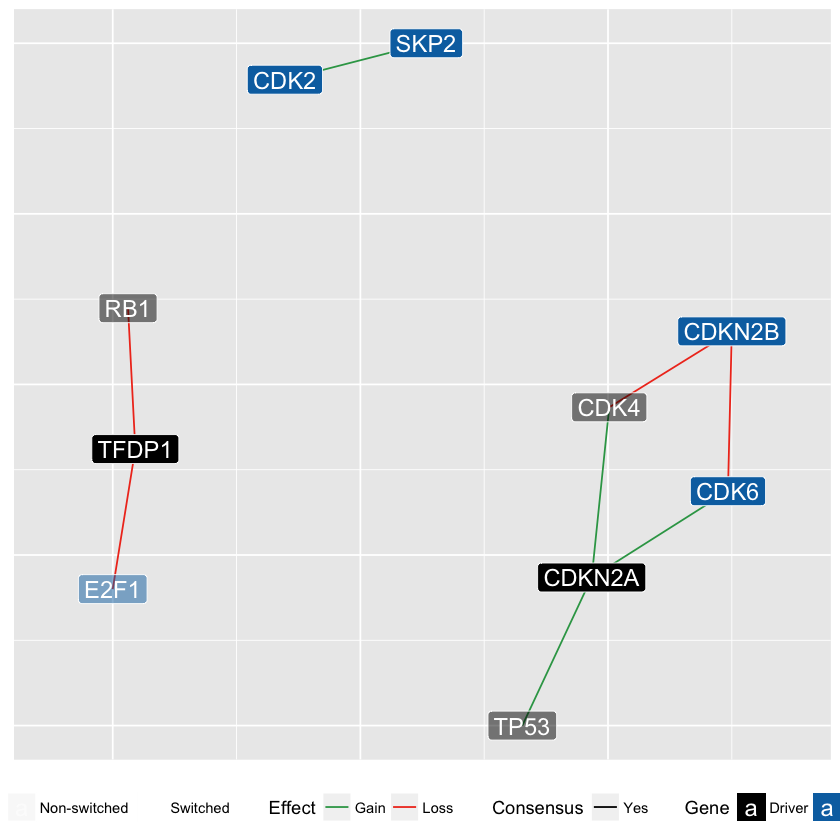

In [13]:
ppi.filt <- merge(ppi, current.switches %>% select(GeneId, Normal_transcript, Tumor_transcript) )

if(any((ppi.filt %>% filter(partnerGeneId %in% BIOCARTA_G1_PATHWAY) %>% select(Tag) %>% unique) != "Unaffected")){
    nw <- getPPINetwork(BIOCARTA_G1_PATHWAY, ppi.network, ppi.filt)

    # number of edges
    length(nw %e% "Effect")

    # add node attributes
    nw %v% "Gene" <- ifelse(nw %v% "vertex.names" %in% drivers, "Driver", "Non-driver")
    nw %v% "Switched" <- ifelse(nw %v% "vertex.names" %in% current.switches$Symbol, "Switched", "Non-switched")

    ggplot(nw, aes(x = x, y = y, xend = xend, yend = yend)) +
        geom_edges(aes(color = Effect, linetype = Consensus)) +
        geom_nodelabel(aes(label = vertex.names, fill = Gene, alpha = Switched), size = 5, color = "white") +
        scale_color_manual(values = ppiPalette) +
        scale_alpha_manual(values = c("Switched" = 1, "Non-switched" = 0.5)) +
        scale_fill_manual(values = c("Driver" = "black", "Non-driver" = "#0570b0")) +
        scale_linetype_manual(values = c("Yes" = "solid", "No" = "dashed")) +
        lims( x = c(-.10, 1.10))+ 
        theme(axis.line=element_blank(),axis.text.x=element_blank(),
              axis.text.y=element_blank(),axis.ticks=element_blank(),
              axis.title.x=element_blank(),axis.title.y=element_blank(),
              legend.position="bottom")
}

# Post-splicing, specifically the subset involved in translation initiation.
## Switches in the pathway

In [14]:
post.splicing <- c("EEF1A1","PABPC1","EIF1","EIF2B1","EIF2B2","EIF2B3","EIF2B4","EIF2B5",
                   "EIF2S1","EIF2S2","EIF2S3","EIF3A","EIF3B","EIF3C","EIF3D","EIF3E","EIF3F",
                   "EIF3G","EIF3H","EIF3I","EIF3J","EIF4A2","EIF4A3","EIF4B","EIF4E",
                   "EIF4EBP1","EIF4G1","EIF5","EIF5B")
post.splicing <- id2symbol %>%
    filter(Symbol %in% post.splicing) %>%
    .$GeneId

# genes with a switch in the pathway
switches %>%
    filter(GeneId %in% post.splicing) %>%
    select(GeneId) %>%
    unique %>%
    nrow

switches %>%
    filter(GeneId %in% post.splicing) %>%
    select(Symbol) %>%
    unique %>%
    t

[1] 13

Symbol,EIF3A,EIF4B,EIF5,EIF3C,EIF2B4,EIF2B5,EIF4A2,EEF1A1,EIF3B,PABPC1,EIF3E,EIF4A3,EIF4E


In [15]:
# check how many cases there are transcripts with the same id (ie similar exon structure and coordinates)
current.switches <- switches %>%
    filter(GeneId %in% post.splicing) %>%
    mutate(Normal_transcript.r = strsplit(Normal_transcript, ".", fixed = T) %>% unlist %>% .[c(T,F)],
           Tumor_transcript.r = strsplit(Tumor_transcript, ".", fixed = T) %>% unlist %>% .[c(T,F)]) %>%
    merge(latestVersion, by.x=c("Normal_transcript.r","CDS_Normal"), by.y=c("Transcript","CDS")) %>%
    merge(latestVersion, by.x=c("Tumor_transcript.r","CDS_Tumor"), by.y=c("Transcript","CDS"))

current.switches$Symbol %>% unique %>% length
current.switches$Symbol %>% unique

[1] 6

[1] "EIF2B4" "EIF4A2" "EIF4E"  "EIF3B"  "EIF4B"  "PABPC1"

In [16]:
# genes were both transcripts are protein-coding and affect a PPI
current.switches %>%
    filter(GeneId %in% post.splicing & PPI == 1 & CDS_Normal == 1 & CDS_Tumor == 1) %>%
    select(GeneId) %>%
    unique %>%
    nrow

current.switches %>%
    filter(GeneId %in% post.splicing & PPI == 1 & CDS_Normal == 1 & CDS_Tumor == 1) %>%
    select(Symbol) %>%
    unique %>%
    t

[1] 1

,1
Symbol,EIF4B


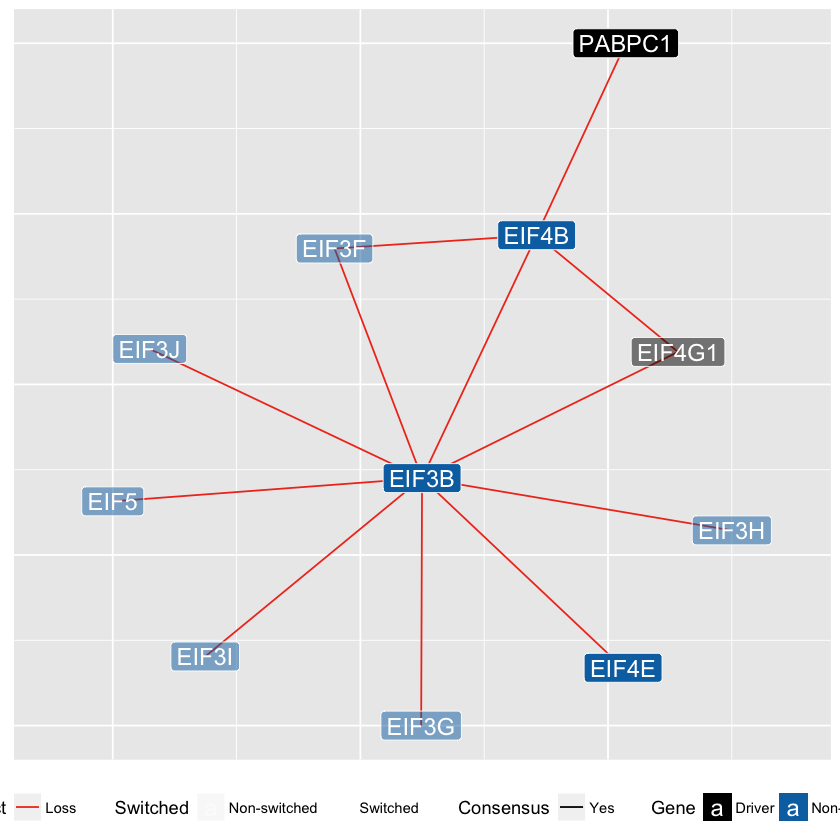

In [17]:
ppi.filt <- merge(ppi, current.switches %>% select(GeneId, Normal_transcript, Tumor_transcript) )

if(any((ppi.filt %>% filter(partnerGeneId %in% post.splicing) %>% select(Tag) %>% unique) != "Unaffected")){
    nw <- getPPINetwork(post.splicing, ppi.network, ppi.filt)

    # number of edges
    length(nw %e% "Effect")

    # add node attributes
    nw %v% "Gene" <- ifelse(nw %v% "vertex.names" %in% drivers, "Driver", "Non-driver")
    nw %v% "Switched" <- ifelse(nw %v% "vertex.names" %in% current.switches$Symbol, "Switched", "Non-switched")

    ggplot(nw, aes(x = x, y = y, xend = xend, yend = yend)) +
        geom_edges(aes(color = Effect, linetype = Consensus)) +
        geom_nodelabel(aes(label = vertex.names, fill = Gene, alpha = Switched), size = 5, color = "white") +
        scale_color_manual(values = ppiPalette) +
        scale_alpha_manual(values = c("Switched" = 1, "Non-switched" = 0.5)) +
        scale_fill_manual(values = c("Driver" = "black", "Non-driver" = "#0570b0")) +
        scale_linetype_manual(values = c("Yes" = "solid", "No" = "dashed")) +
        lims( x = c(-.10, 1.10))+ 
        theme(axis.line=element_blank(),axis.text.x=element_blank(),
              axis.text.y=element_blank(),axis.ticks=element_blank(),
              axis.title.x=element_blank(),axis.title.y=element_blank(),
              legend.position="bottom")
}

# REACTOME_PI3K_EVENTS_IN_ERBB2_SIGNALING

In [18]:
REACTOME_PI3K_EVENTS_IN_ERBB2_SIGNALING <- c(10000,1026,1027,1147,117145,1385,145957,1839,1950,
                                             1956,2064,2065,2066,2069,207,208,2308,2309,23239,
                                             2475,253260,2549,2885,2931,3084,3164,4193,4303,
                                             5170,5290,5295,572,5728,57761,6199,64223,685,
                                             7249,729120,731292,79109,842,84335,9542)

# genes with a switch in the pathway
switches %>%
    filter(GeneId %in% REACTOME_PI3K_EVENTS_IN_ERBB2_SIGNALING) %>%
    select(GeneId) %>%
    unique %>%
    nrow

switches %>%
    filter(GeneId %in% REACTOME_PI3K_EVENTS_IN_ERBB2_SIGNALING) %>%
    select(Symbol) %>%
    unique %>%
    t

[1] 17

Symbol,CASP9,THEM4,RPS6KB2,ERBB3,MDM2,TSC2,MLST8,ERBB2,GRB2,AKT2,AKT1S1,NRG2,NRG1,MAPKAP1,AKT1,ERBB4,GAB1


In [19]:
# check how many cases there are transcripts with the same id (ie similar exon structure and coordinates)
current.switches <- switches %>%
    filter(GeneId %in% REACTOME_PI3K_EVENTS_IN_ERBB2_SIGNALING) %>%
    mutate(Normal_transcript.r = strsplit(Normal_transcript, ".", fixed = T) %>% unlist %>% .[c(T,F)],
           Tumor_transcript.r = strsplit(Tumor_transcript, ".", fixed = T) %>% unlist %>% .[c(T,F)]) %>%
    merge(latestVersion, by.x=c("Normal_transcript.r","CDS_Normal"), by.y=c("Transcript","CDS")) %>%
    merge(latestVersion, by.x=c("Tumor_transcript.r","CDS_Tumor"), by.y=c("Transcript","CDS"))

current.switches$Symbol %>% unique %>% length
current.switches$Symbol %>% unique

[1] 8

[1] "CASP9"  "ERBB3"  "MLST8"  "GRB2"   "AKT1S1" "GAB1"   "NRG2"   "ERBB2"

In [20]:
# genes were both transcripts are protein-coding and affect a PPI
current.switches %>%
    filter(GeneId %in% REACTOME_PI3K_EVENTS_IN_ERBB2_SIGNALING & PPI == 1 & CDS_Normal == 1 & CDS_Tumor == 1) %>%
    select(GeneId) %>%
    unique %>%
    nrow

current.switches %>%
    filter(GeneId %in% REACTOME_PI3K_EVENTS_IN_ERBB2_SIGNALING & PPI == 1 & CDS_Normal == 1 & CDS_Tumor == 1) %>%
    select(Symbol) %>%
    unique %>%
    t

[1] 3

,1,2,3
Symbol,ERBB3,GRB2,GAB1


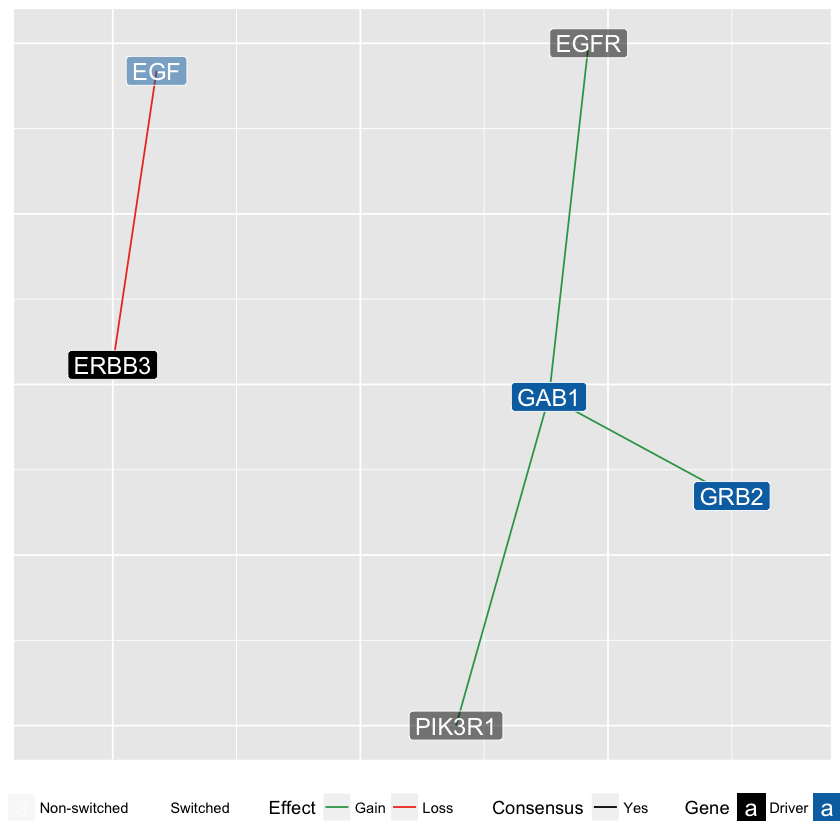

In [21]:
ppi.filt <- merge(ppi, current.switches %>% select(GeneId, Normal_transcript, Tumor_transcript) )

if(any((ppi.filt %>% filter(partnerGeneId %in% REACTOME_PI3K_EVENTS_IN_ERBB2_SIGNALING) %>% select(Tag) %>% unique) != "Unaffected")){
    nw <- getPPINetwork(REACTOME_PI3K_EVENTS_IN_ERBB2_SIGNALING, ppi.network, ppi.filt)

    # number of edges
    length(nw %e% "Effect")

    # add node attributes
    nw %v% "Gene" <- ifelse(nw %v% "vertex.names" %in% drivers, "Driver", "Non-driver")
    nw %v% "Switched" <- ifelse(nw %v% "vertex.names" %in% current.switches$Symbol, "Switched", "Non-switched")

    ggplot(nw, aes(x = x, y = y, xend = xend, yend = yend)) +
        geom_edges(aes(color = Effect, linetype = Consensus)) +
        geom_nodelabel(aes(label = vertex.names, fill = Gene, alpha = Switched), size = 5, color = "white") +
        scale_color_manual(values = ppiPalette) +
        scale_alpha_manual(values = c("Switched" = 1, "Non-switched" = 0.5)) +
        scale_fill_manual(values = c("Driver" = "black", "Non-driver" = "#0570b0")) +
        scale_linetype_manual(values = c("Yes" = "solid", "No" = "dashed")) +
        lims( x = c(-.10, 1.10))+ 
        theme(axis.line=element_blank(),axis.text.x=element_blank(),
              axis.text.y=element_blank(),axis.ticks=element_blank(),
              axis.title.x=element_blank(),axis.title.y=element_blank(),
              legend.position="bottom")
}

# KEGG_ERBB_SIGNALING_PATHWAY

In [22]:
KEGG_ERBB_SIGNALING_PATHWAY <- c(3725,6655,5063,5894,5579,685,6464,5578,2002,3084,5062,
                                 2475,10298,6416,1978,572,5582,10718,5601,2066,5602,5747,
                                 2064,2065,5605,7039,673,5604,5609,25,9542,207,27,208,
                                 399694,6198,6199,10000,4893,2885,374,6777,5595,6776,
                                 56924,6654,4609,5594,4690,23533,145957,3265,5599,1956,
                                 2932,868,3845,867,53358,1027,1026,1950,2069,369,8440,
                                 57144,6714,8503,815,816,817,818,5058,23624,1398,5290,
                                 5291,1399,5293,2549,5335,5336,25759,1839,5294,5295,5296)

# genes with a switch in the pathway
switches %>%
    filter(GeneId %in% KEGG_ERBB_SIGNALING_PATHWAY) %>%
    select(GeneId) %>%
    unique %>%
    nrow

switches %>%
    filter(GeneId %in% KEGG_ERBB_SIGNALING_PATHWAY) %>%
    select(Symbol) %>%
    unique %>%
    t

[1] 33

Symbol,PIK3R3,CAMK2G,RPS6KB2,PAK1,ERBB3,SOS2,CRK,ERBB2,STAT5A,GRB2,⋯,NRG1,PTK2,ABL1,ELK1,PAK3,AKT1,PAK6,MAP2K1,ERBB4,GAB1


In [23]:
# check how many cases there are transcripts with the same id (ie similar exon structure and coordinates)
current.switches <- switches %>%
    filter(GeneId %in% KEGG_ERBB_SIGNALING_PATHWAY) %>%
    mutate(Normal_transcript.r = strsplit(Normal_transcript, ".", fixed = T) %>% unlist %>% .[c(T,F)],
           Tumor_transcript.r = strsplit(Tumor_transcript, ".", fixed = T) %>% unlist %>% .[c(T,F)]) %>%
    merge(latestVersion, by.x=c("Normal_transcript.r","CDS_Normal"), by.y=c("Transcript","CDS")) %>%
    merge(latestVersion, by.x=c("Tumor_transcript.r","CDS_Tumor"), by.y=c("Transcript","CDS"))

current.switches$Symbol %>% unique %>% length
current.switches$Symbol %>% unique

[1] 12

[1] "ERBB3"  "CRK"    "GRB2"   "PAK4"   "TGFA"   "NCK2"   "GAB1"   "NRG2"  
 [9] "PIK3CG" "ABL1"   "STAT5A" "ERBB2"

In [24]:
# genes were both transcripts are protein-coding and affect a PPI
current.switches %>%
    filter(GeneId %in% KEGG_ERBB_SIGNALING_PATHWAY & PPI == 1 & CDS_Normal == 1 & CDS_Tumor == 1) %>%
    select(GeneId) %>%
    unique %>%
    nrow

current.switches %>%
    filter(GeneId %in% KEGG_ERBB_SIGNALING_PATHWAY & PPI == 1 & CDS_Normal == 1 & CDS_Tumor == 1) %>%
    select(Symbol) %>%
    unique %>%
    t

[1] 4

,1,2,3,4
Symbol,ERBB3,GRB2,NCK2,GAB1


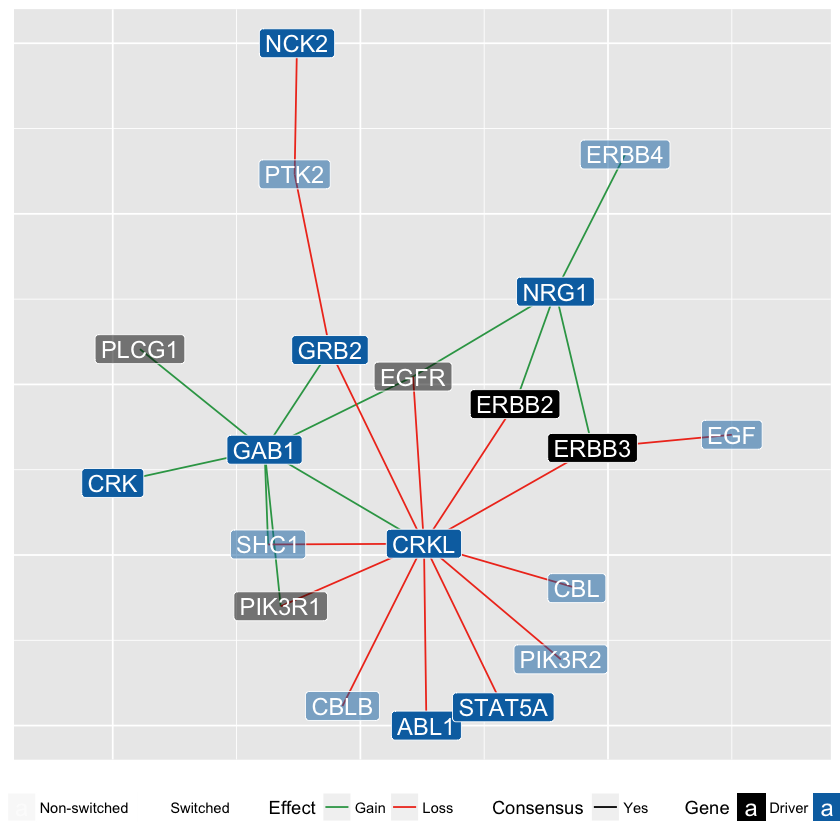

In [25]:
ppi.filt <- merge(ppi, current.switches %>% select(GeneId, Normal_transcript, Tumor_transcript) )

ppi.filt <- merge(ppi, switches %>% 
                          filter(Symbol %in% c("CRKL","NRG1") & PPI==1) %>% 
                          select(GeneId, Normal_transcript, Tumor_transcript) ) %>%
    rbind(ppi.filt)

if(any((ppi.filt %>% filter(partnerGeneId %in% KEGG_ERBB_SIGNALING_PATHWAY) %>% select(Tag) %>% unique) != "Unaffected")){
    nw <- getPPINetwork(KEGG_ERBB_SIGNALING_PATHWAY, ppi.network, ppi.filt)

    # number of edges
    length(nw %e% "Effect")

    # add node attributes
    nw %v% "Gene" <- ifelse(nw %v% "vertex.names" %in% drivers, "Driver", "Non-driver")
    nw %v% "Switched" <- ifelse(nw %v% "vertex.names" %in% current.switches$Symbol, "Switched", "Non-switched")
    nw %v% "Switched" <- ifelse(nw %v% "vertex.names" %in% c("CRKL","NRG1"), "Switched", nw %v% "Switched")

    ggplot(nw, aes(x = x, y = y, xend = xend, yend = yend)) +
        geom_edges(aes(color = Effect, linetype = Consensus)) +
        geom_nodelabel(aes(label = vertex.names, fill = Gene, alpha = Switched), size = 5, color = "white") +
        scale_color_manual(values = ppiPalette) +
        scale_alpha_manual(values = c("Switched" = 1, "Non-switched" = 0.5)) +
        scale_fill_manual(values = c("Driver" = "black", "Non-driver" = "#0570b0")) +
        scale_linetype_manual(values = c("Yes" = "solid", "No" = "dashed")) +
        lims( x = c(-.10, 1.10))+ 
        theme(axis.line=element_blank(),axis.text.x=element_blank(),
              axis.text.y=element_blank(),axis.ticks=element_blank(),
              axis.title.x=element_blank(),axis.title.y=element_blank(),
              legend.position="bottom")
}

# KEGG_FOCAL_ADHESION

In [26]:
KEGG_FOCAL_ADHESION <- c(3725,100418883,2002,3082,55742,2335,63923,3479,330,331,1311,
                         7060,3480,1729,22801,5228,64098,6093,5747,58498,2321,2324,207,
                         5649,208,3918,10627,3913,3914,3915,3910,3911,3912,56924,23533,
                         824,22798,2318,2316,2317,4633,4638,4636,23396,4233,93408,329,
                         1301,10319,1302,7059,7058,7057,7450,7791,3381,7448,80310,4659,
                         572,81,87,5601,5602,646821,5604,5923,3611,2889,2885,5501,5500,
                         71,8515,3265,8516,1499,103910,60,9475,5728,5906,8503,5908,3371,
                         858,857,859,50509,7094,10451,1292,1293,1290,1291,284217,3680,1101,
                         10298,3676,3675,3674,3679,3678,1289,1288,5159,1280,1281,1282,29780,
                         1284,673,1286,7409,5170,3690,3691,7408,3693,399694,3694,1793,3695,
                         3685,3688,10000,7410,6696,1277,1278,83660,56034,7414,53358,7422,7424,
                         3696,7423,5829,57144,595,5154,596,5155,5156,394,9564,5058,2277,1398,
                         1399,894,998,88,896,89,6655,5063,5579,5894,5578,6464,5062,10398,387,
                         5582,29895,2064,5880,5881,3791,85366,5499,5595,2909,5879,6654,5594,
                         5599,1956,2932,7143,1950,3909,7148,3908,3655,3673,6714,3672,5290,5291,
                         5293,25759,131873,91807,2534,5294,5295,5296)

# genes with a switch in the pathway
switches %>%
    filter(GeneId %in% KEGG_FOCAL_ADHESION) %>%
    select(GeneId) %>%
    unique %>%
    nrow

switches %>%
    filter(GeneId %in% KEGG_FOCAL_ADHESION) %>%
    select(Symbol) %>%
    unique %>%
    t

[1] 78

Symbol,CDC42,PIK3R3,VAV3,RAP1A,THBS3,LAMB3,CAPN2,ITGA8,ITGB1,VCL,⋯,XIAP,AKT1,PAK6,ITGA3,CHAD,FLNB,RELN,TNC,MAP2K1,MYLK


In [27]:
# check how many cases there are transcripts with the same id (ie similar exon structure and coordinates)
current.switches <- switches %>%
    filter(GeneId %in% KEGG_FOCAL_ADHESION) %>%
    mutate(Normal_transcript.r = strsplit(Normal_transcript, ".", fixed = T) %>% unlist %>% .[c(T,F)],
           Tumor_transcript.r = strsplit(Tumor_transcript, ".", fixed = T) %>% unlist %>% .[c(T,F)]) %>%
    merge(latestVersion, by.x=c("Normal_transcript.r","CDS_Normal"), by.y=c("Transcript","CDS")) %>%
    merge(latestVersion, by.x=c("Tumor_transcript.r","CDS_Tumor"), by.y=c("Transcript","CDS"))

current.switches$Symbol %>% unique %>% length
current.switches$Symbol %>% unique

[1] 36

[1] "ITGB1"    "VEGFB"    "PDGFD"    "ITGA7"    "PXN"      "TLN2"    
 [7] "CRK"      "GRB2"     "ITGB4"    "MYL12A"   "PAK4"     "PPP1CB"  
[13] "PARVB"    "CAV3"     "CTNNB1"   "FLNB"     "CCND3"    "PDGFA"   
[19] "RAC1"     "PIK3CG"   "FLNC"     "TNC"      "THBS3"    "LAMB3"   
[25] "ITGA11"   "IGF1R"    "ITGA3"    "CHAD"     "CAV1"     "XIAP"    
[31] "CAPN2"    "RAP1B"    "PPP1R12A" "ACTN1"    "ERBB2"    "ITGB8"

In [28]:
# genes were both transcripts are protein-coding and affect a PPI
current.switches %>%
    filter(GeneId %in% KEGG_FOCAL_ADHESION & PPI == 1 & CDS_Normal == 1 & CDS_Tumor == 1) %>%
    select(GeneId) %>%
    unique %>%
    nrow

current.switches %>%
    filter(GeneId %in% KEGG_FOCAL_ADHESION & PPI == 1 & CDS_Normal == 1 & CDS_Tumor == 1) %>%
    select(Symbol) %>%
    unique %>%
    t

[1] 2

,1,2
Symbol,GRB2,CCND3


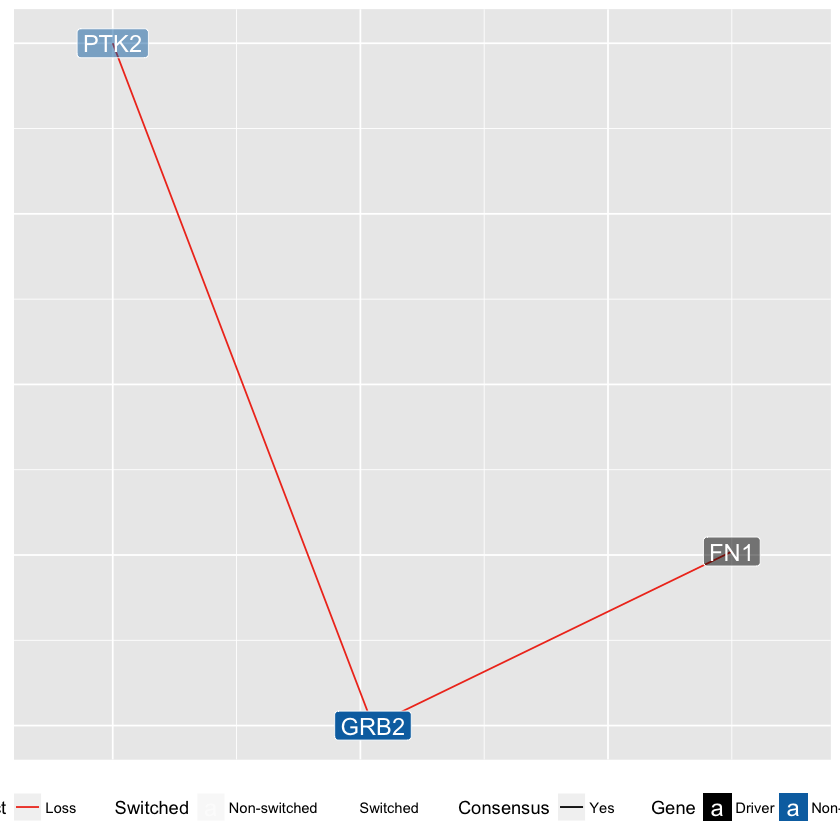

In [29]:
ppi.filt <- merge(ppi, current.switches %>% select(GeneId, Normal_transcript, Tumor_transcript) )

if(any((ppi.filt %>% filter(partnerGeneId %in% KEGG_FOCAL_ADHESION) %>% select(Tag) %>% unique) != "Unaffected")){
    nw <- getPPINetwork(KEGG_FOCAL_ADHESION, ppi.network, ppi.filt)

    # number of edges
    length(nw %e% "Effect")

    # add node attributes
    nw %v% "Gene" <- ifelse(nw %v% "vertex.names" %in% drivers, "Driver", "Non-driver")
    nw %v% "Switched" <- ifelse(nw %v% "vertex.names" %in% current.switches$Symbol, "Switched", "Non-switched")

    ggplot(nw, aes(x = x, y = y, xend = xend, yend = yend)) +
        geom_edges(aes(color = Effect, linetype = Consensus)) +
        geom_nodelabel(aes(label = vertex.names, fill = Gene, alpha = Switched), size = 5, color = "white") +
        scale_color_manual(values = ppiPalette) +
        scale_alpha_manual(values = c("Switched" = 1, "Non-switched" = 0.5)) +
        scale_fill_manual(values = c("Driver" = "black", "Non-driver" = "#0570b0")) +
        scale_linetype_manual(values = c("Yes" = "solid", "No" = "dashed")) +
        lims( x = c(-.10, 1.10))+ 
        theme(axis.line=element_blank(),axis.text.x=element_blank(),
              axis.text.y=element_blank(),axis.ticks=element_blank(),
              axis.title.x=element_blank(),axis.title.y=element_blank(),
              legend.position="bottom")
}

# Spliceosome module

In [30]:
SPLICEOSOME <- c("CNBP","IPO13","RSL1D1","HNRNPU","HNRNPF","UBE2E3","DHX15","NHP2L1","RBM39",
             "RBMX","RBM11","TARDBP","EEF1A1","EEF1D","DDX5","PABPC1","UBE2E1","SFRS6",
             "HNRNPD","CHD1","RBM7","SYNCRIP","EEF1A2","PSPC1","SFRS11","HNRNPR","MAPK9",
             "CLK3","RNF167","GAS7","SUMO1","HNRNPA1","SF1","RBM25","SFRS4","MYB","BMPR1A",
             "TRA2B","HNRNPC","RBMS2","SFRS7","RPL31","WBP4","SFRS13A","PTBP1","HNRNPM",
             "SNRNP70","SNRPA","EWSR1","TDRD3","RNPS1","SFRS1","ZMYND11","NUDT21","CDK11B",
             "VARS","BTRC","CPSF6","ELAVL1","NXT1","PRPF8","NUP98","PRPF4","SFRS3","NXF1","SAE1",
             "RBM41","HNRNPA0","SUMO2","SFRS9","SF3B4","YBX1","SRPK1","RAN","HNRPDL","MKI67IP","THOC4",
             "TCERG1","U2AF2","EIF4H","FBL","MAGOH","HNRNPH1","SFPQ","SUMO3","SFRS5","TNPO1","NUP133",
             "UBA2","FUS","HNRNPA3","DDX17","SFRS2","PUF60","IPO11","THRA","HNRNPA2B1","PCBP1","SF3B1",
             "UBE2I","CDK19","EIF6","TNPO3","SNRPD2","CIRBP","TRA2A","RBBP6","NONO","TNPO2","SF3B2",
             "DUSP11","U2AF1","SF3B14","SFRS12","NUTF2","KPNA3","SNRPB2","KHDRBS2")
SPLICEOSOME <- id2symbol %>%
    filter(Symbol %in% SPLICEOSOME) %>%
    .$GeneId

# genes with a switch in the pathway
switches %>%
    filter(GeneId %in% SPLICEOSOME) %>%
    select(GeneId) %>%
    unique %>%
    nrow

switches %>%
    filter(GeneId %in% SPLICEOSOME) %>%
    select(Symbol) %>%
    unique %>%
    t

[1] 58

Symbol,TARDBP,SFRS4,SFPQ,IPO13,SFRS11,SF3B4,HNRNPU,HNRNPF,BMPR1A,NXF1,⋯,SYNCRIP,TNPO3,PABPC1,PUF60,PRPF4,RBM41,RBMX,TDRD3,SFRS13A,SFRS6


In [31]:
# check how many cases there are transcripts with the same id (ie similar exon structure and coordinates)
current.switches <- switches %>%
    filter(GeneId %in% SPLICEOSOME) %>%
    mutate(Normal_transcript.r = strsplit(Normal_transcript, ".", fixed = T) %>% unlist %>% .[c(T,F)],
           Tumor_transcript.r = strsplit(Tumor_transcript, ".", fixed = T) %>% unlist %>% .[c(T,F)]) %>%
    merge(latestVersion, by.x=c("Normal_transcript.r","CDS_Normal"), by.y=c("Transcript","CDS")) %>%
    merge(latestVersion, by.x=c("Tumor_transcript.r","CDS_Tumor"), by.y=c("Transcript","CDS"))

current.switches$Symbol %>% unique %>% length
current.switches$Symbol %>% unique

[1] 23

[1] "IPO13"   "NXF1"    "TDRD3"   "HNRNPC"  "RNPS1"   "THRA"    "SFRS1"  
 [8] "SNRPB2"  "NHP2L1"  "UBE2E1"  "CNBP"    "TRA2B"   "HNRNPD"  "IPO11"  
[15] "SYNCRIP" "PUF60"   "PRPF4"   "RBM41"   "DDX5"    "SF1"     "RBMS2"  
[22] "SFRS2"   "PABPC1"

In [32]:
# genes were both transcripts are protein-coding and affect a PPI
current.switches %>%
    filter(GeneId %in% SPLICEOSOME & PPI == 1 & CDS_Normal == 1 & CDS_Tumor == 1) %>%
    select(GeneId) %>%
    unique %>%
    nrow

current.switches %>%
    filter(GeneId %in% SPLICEOSOME & PPI == 1 & CDS_Normal == 1 & CDS_Tumor == 1) %>%
    select(Symbol) %>%
    unique %>%
    t

[1] 4

,1,2,3,4
Symbol,IPO13,NXF1,IPO11,RBMS2


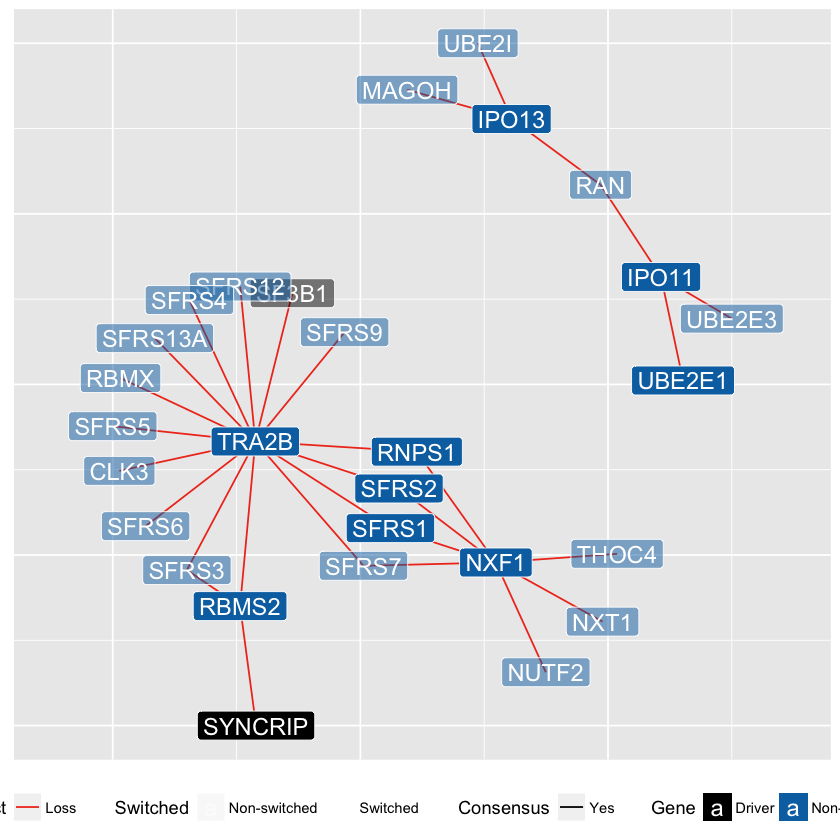

In [33]:
ppi.filt <- merge(ppi, current.switches %>% select(GeneId, Normal_transcript, Tumor_transcript) )

if(any((ppi.filt %>% filter(partnerGeneId %in% SPLICEOSOME) %>% select(Tag) %>% unique) != "Unaffected")){
    nw <- getPPINetwork(SPLICEOSOME, ppi.network, ppi.filt)

    # number of edges
    length(nw %e% "Effect")

    # add node attributes
    nw %v% "Gene" <- ifelse(nw %v% "vertex.names" %in% drivers, "Driver", "Non-driver")
    nw %v% "Switched" <- ifelse(nw %v% "vertex.names" %in% current.switches$Symbol, "Switched", "Non-switched")

    ggplot(nw, aes(x = x, y = y, xend = xend, yend = yend)) +
        geom_edges(aes(color = Effect, linetype = Consensus)) +
        geom_nodelabel(aes(label = vertex.names, fill = Gene, alpha = Switched), size = 5, color = "white") +
        scale_color_manual(values = ppiPalette) +
        scale_alpha_manual(values = c("Switched" = 1, "Non-switched" = 0.5)) +
        scale_fill_manual(values = c("Driver" = "black", "Non-driver" = "#0570b0")) +
        scale_linetype_manual(values = c("Yes" = "solid", "No" = "dashed")) +
        lims( x = c(-.10, 1.10))+ 
        theme(axis.line=element_blank(),axis.text.x=element_blank(),
              axis.text.y=element_blank(),axis.ticks=element_blank(),
              axis.title.x=element_blank(),axis.title.y=element_blank(),
              legend.position="bottom")
}

# EIFs module

In [34]:
EIFs <- c("EIF3B","EIF4G1","EIF5","DDX3X","EIF3J","EIF4E","EIF4A1","CSNK2A2","EIF3H","EIF3F","EIF4B","EIF3G","EIF3I")
EIFs <- id2symbol %>%
    filter(Symbol %in% EIFs) %>%
    .$GeneId

# genes with a switch in the pathway
switches %>%
    filter(GeneId %in% EIFs) %>%
    select(GeneId) %>%
    unique %>%
    nrow

switches %>%
    filter(GeneId %in% EIFs) %>%
    select(Symbol) %>%
    unique %>%
    t

[1] 4

Symbol,EIF4B,EIF5,EIF3B,EIF4E


In [35]:
# check how many cases there are transcripts with the same id (ie similar exon structure and coordinates)
current.switches <- switches %>%
    filter(GeneId %in% EIFs) %>%
    mutate(Normal_transcript.r = strsplit(Normal_transcript, ".", fixed = T) %>% unlist %>% .[c(T,F)],
           Tumor_transcript.r = strsplit(Tumor_transcript, ".", fixed = T) %>% unlist %>% .[c(T,F)]) %>%
    merge(latestVersion, by.x=c("Normal_transcript.r","CDS_Normal"), by.y=c("Transcript","CDS")) %>%
    merge(latestVersion, by.x=c("Tumor_transcript.r","CDS_Tumor"), by.y=c("Transcript","CDS"))

current.switches$Symbol %>% unique %>% length
current.switches$Symbol %>% unique

[1] 3

[1] "EIF4E" "EIF3B" "EIF4B"

In [36]:
# genes were both transcripts are protein-coding and affect a PPI
current.switches %>%
    filter(GeneId %in% EIFs & PPI == 1 & CDS_Normal == 1 & CDS_Tumor == 1) %>%
    select(GeneId) %>%
    unique %>%
    nrow

current.switches %>%
    filter(GeneId %in% EIFs & PPI == 1 & CDS_Normal == 1 & CDS_Tumor == 1) %>%
    select(Symbol) %>%
    unique %>%
    t

[1] 1

,1
Symbol,EIF4B


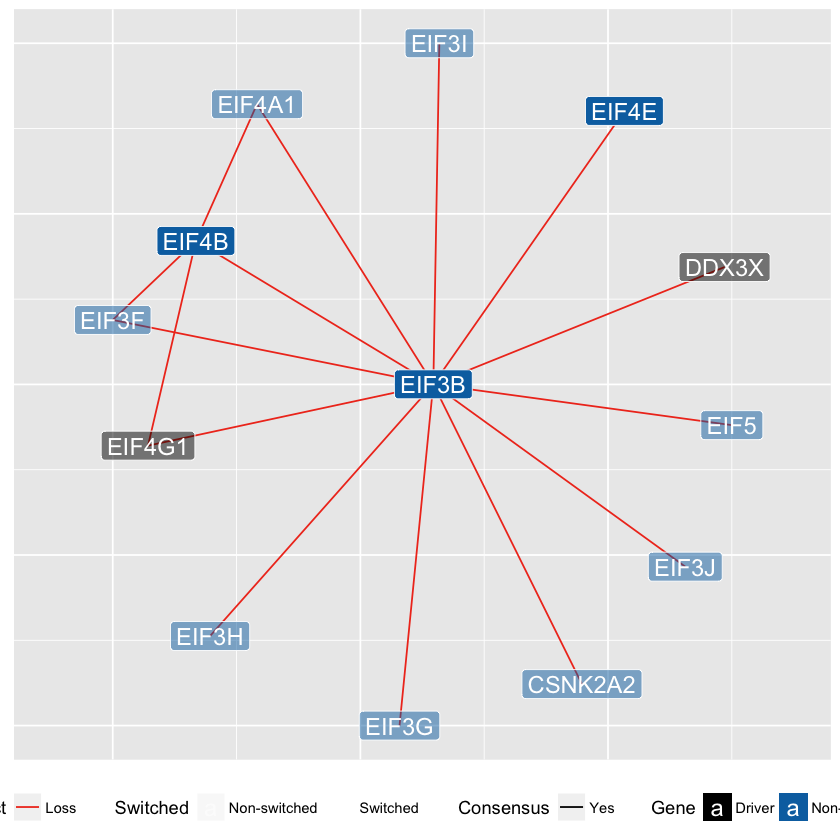

In [37]:
ppi.filt <- merge(ppi, current.switches %>% select(GeneId, Normal_transcript, Tumor_transcript) )

if(any((ppi.filt %>% filter(partnerGeneId %in% EIFs) %>% select(Tag) %>% unique) != "Unaffected")){
    nw <- getPPINetwork(EIFs, ppi.network, ppi.filt)

    # number of edges
    length(nw %e% "Effect")

    # add node attributes
    nw %v% "Gene" <- ifelse(nw %v% "vertex.names" %in% drivers, "Driver", "Non-driver")
    nw %v% "Switched" <- ifelse(nw %v% "vertex.names" %in% current.switches$Symbol, "Switched", "Non-switched")

    ggplot(nw, aes(x = x, y = y, xend = xend, yend = yend)) +
        geom_edges(aes(color = Effect, linetype = Consensus)) +
        geom_nodelabel(aes(label = vertex.names, fill = Gene, alpha = Switched), size = 5, color = "white") +
        scale_color_manual(values = ppiPalette) +
        scale_alpha_manual(values = c("Switched" = 1, "Non-switched" = 0.5)) +
        scale_fill_manual(values = c("Driver" = "black", "Non-driver" = "#0570b0")) +
        scale_linetype_manual(values = c("Yes" = "solid", "No" = "dashed")) +
        lims( x = c(-.10, 1.10))+ 
        theme(axis.line=element_blank(),axis.text.x=element_blank(),
              axis.text.y=element_blank(),axis.ticks=element_blank(),
              axis.title.x=element_blank(),axis.title.y=element_blank(),
              legend.position="bottom")
}